In [2]:
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.stat import Correlation
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, avg
from pyspark.ml import Pipeline

In [3]:
sdf = spark.read.parquet("gs://my-project-bucket-flight-prices/trusted/trusted_itineraries.parquet")
sdf.printSchema()
sdf.count()

root
 |-- searchDate: string (nullable = true)
 |-- flightDate: string (nullable = true)
 |-- StartingAirport: string (nullable = true)
 |-- DestinationAirport: string (nullable = true)
 |-- fareBasisCode: string (nullable = true)
 |-- isBasicEconomy: double (nullable = true)
 |-- isRefundable: double (nullable = true)
 |-- isNonStop: double (nullable = true)
 |-- totalFare: double (nullable = true)
 |-- seatsRemaining: long (nullable = true)
 |-- totalTravelDistance: double (nullable = true)
 |-- segmentsDepartureTimeEpochSeconds: string (nullable = true)
 |-- segmentsDepartureTimeRaw: string (nullable = true)
 |-- segmentsArrivalTimeRaw: string (nullable = true)
 |-- segmentsArrivalAirportCode: string (nullable = true)
 |-- segmentsDepartureAirportCode: string (nullable = true)
 |-- SegmentsAirlineName: string (nullable = true)
 |-- segmentsAirlineCode: string (nullable = true)
 |-- segmentsEquipmentDescription: string (nullable = true)
 |-- segmentsDurationInSeconds: string (nullabl

1323791

In [4]:
sdf = sdf.sample(False, 0.1)

In [5]:
sdf_cleaned = sdf.dropna()


In [6]:
feature_columns = [
    "StartingAirport_OneHot", "DestinationAirport_OneHot", "fareBasisCode_OneHot", 
    "SegmentsAirlineName_OneHot", "Route_OneHot", "SeatsRemainingCategory_OneHot", 
    "totalTravelDistance_Scaled"
]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(sdf_cleaned)

linear_reg = LinearRegression(featuresCol='features', labelCol='totalFare')
evaluator = RegressionEvaluator(labelCol='totalFare')

24/12/03 04:07:03 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


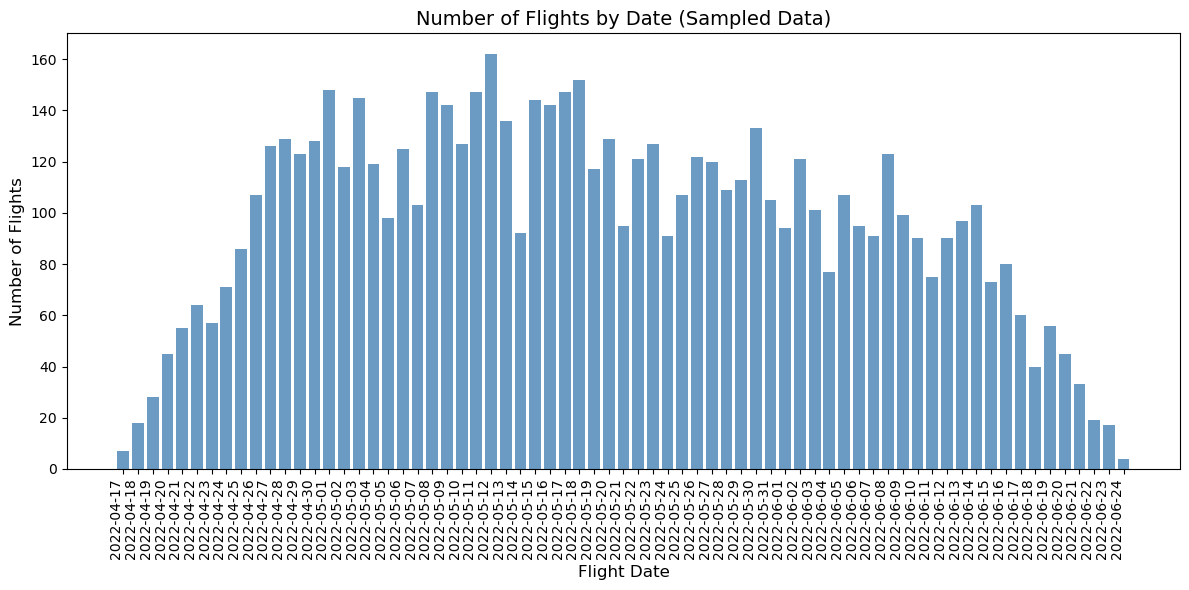

In [9]:
# Take a random sample from the cleaned DataFrame
sample_sdf = sdf_cleaned.sample(fraction=0.05, seed=42)

# Filter and group by flightDate in the sampled data
summary_sdf = sample_sdf.filter(col("flightDate").isNotNull()) \
    .groupBy("flightDate") \
    .count() \
    .sort("flightDate")

# Convert the summarized Spark DataFrame to Pandas for visualization
df = summary_sdf.toPandas()

# Create a bar plot using Matplotlib
fig = plt.figure(facecolor='white', figsize=(12, 6))
plt.bar(df['flightDate'], df['count'], color='steelblue', alpha=0.8)

# Add labels and title
plt.xlabel("Flight Date", fontsize=12)
plt.ylabel("Number of Flights", fontsize=12)
plt.title("Number of Flights by Date (Sampled Data)", fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=90, ha='right', fontsize=10)

# Adjust layout for a tight fit
fig.tight_layout()

# Save the plot to a file
plt.savefig("flights_count_by_date_sampled.png", dpi=300)

# Display the plot
plt.show()

<function matplotlib.pyplot.savefig(*args, **kwargs) -> 'None'>

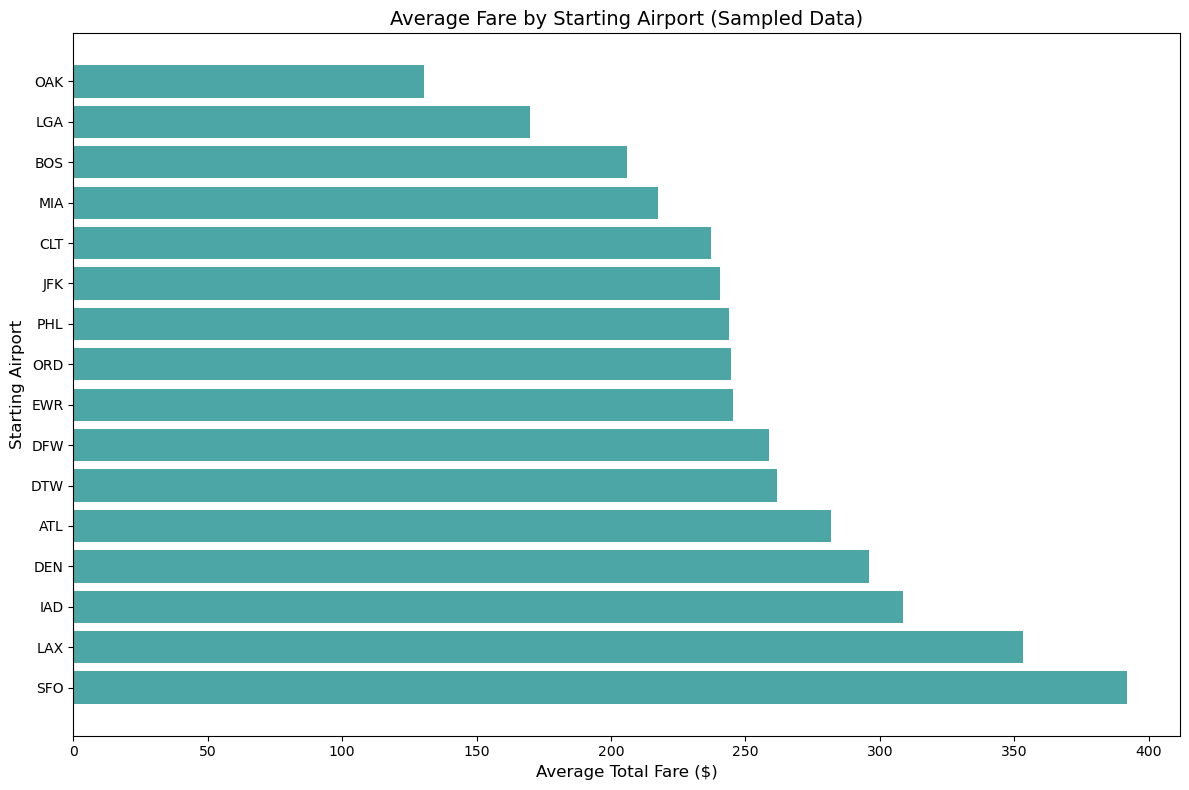

In [10]:
# Take a smaller random sample from the cleaned data
sample_sdf = sdf_cleaned.sample(fraction=0.05, seed=42)

# Group by StartingAirport and calculate the average fare
summary_sdf = sample_sdf.filter(col("StartingAirport").isNotNull()) \
    .groupBy("StartingAirport") \
    .agg(avg("totalFare").alias("averageFare")) \
    .sort("averageFare", ascending=False)

# Convert the summarized Spark DataFrame to Pandas
df = summary_sdf.toPandas()

# Create a horizontal bar plot using Matplotlib
fig = plt.figure(facecolor='white', figsize=(12, 8))
plt.barh(df['StartingAirport'], df['averageFare'], color='teal', alpha=0.7)

# Add labels and title
plt.xlabel("Average Total Fare ($)", fontsize=12)
plt.ylabel("Starting Airport", fontsize=12)
plt.title("Average Fare by Starting Airport (Sampled Data)", fontsize=14)

# Adjust layout for a tight fit
fig.tight_layout()

# Save the plot to a file
plt.savefig

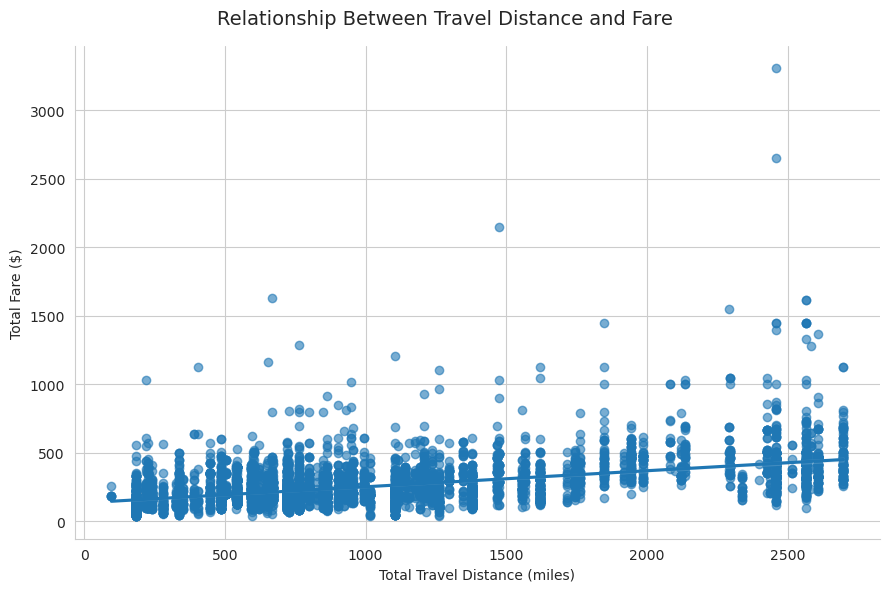

In [11]:
# Take a smaller random sample for visualization
sample_sdf = sdf_cleaned.sample(fraction=0.05, seed=42)

# Select relevant columns and convert to Pandas for visualization
df = sample_sdf.select('totalFare', 'totalTravelDistance').toPandas()

# Set the style for Seaborn plots
sns.set_style("whitegrid")

# Create the relationship plot
relationship_plot = sns.lmplot(x='totalTravelDistance', y='totalFare', data=df, height=6, aspect=1.5, scatter_kws={"alpha": 0.6})

# Add titles and labels
relationship_plot.set_axis_labels("Total Travel Distance (miles)", "Total Fare ($)")
relationship_plot.fig.suptitle("Relationship Between Travel Distance and Fare", fontsize=14)

# Adjust layout
relationship_plot.fig.tight_layout()

# Save the plot to a file
relationship_plot.savefig("relationship_travel_distance_fare.png", dpi=300)

# Show the plot
plt.show()

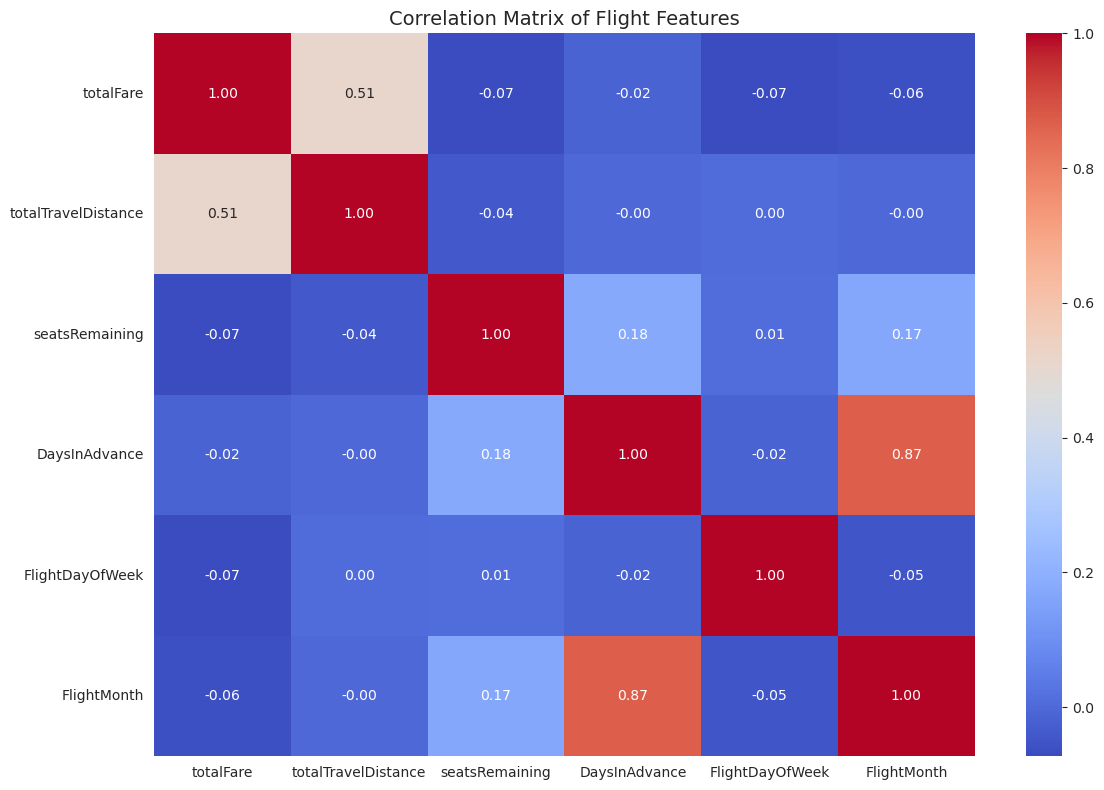

In [12]:
# Define the numeric columns to analyze
numeric_columns = ['totalFare', 'totalTravelDistance', 'seatsRemaining', 'DaysInAdvance', 'FlightDayOfWeek', 'FlightMonth']

# Assemble the numeric columns into a vector
vector_column = "correlation_features"
assembler = VectorAssembler(inputCols=numeric_columns, outputCol=vector_column)
sdf_vector = assembler.transform(sdf_cleaned).select(vector_column)

# Compute the correlation matrix
matrix = Correlation.corr(sdf_vector, vector_column).collect()[0][0]
correlation_matrix = matrix.toArray().tolist()

# Convert the correlation matrix to a Pandas DataFrame
correlation_matrix_df = pd.DataFrame(data=correlation_matrix, columns=numeric_columns, index=numeric_columns)

# Plot the correlation matrix as a heatmap using Seaborn
heatmap_plot = plt.figure(figsize=(12, 8))
sns.set_style("white")

sns.heatmap(correlation_matrix_df, 
            xticklabels=correlation_matrix_df.columns.values,
            yticklabels=correlation_matrix_df.columns.values, 
            cmap="coolwarm", annot=True, fmt=".2f")

# Add title and save the plot
plt.title("Correlation Matrix of Flight Features", fontsize=14)
plt.tight_layout()
plt.savefig("correlation_matrix_flights.png", dpi=300)

# Display the plot
plt.show()

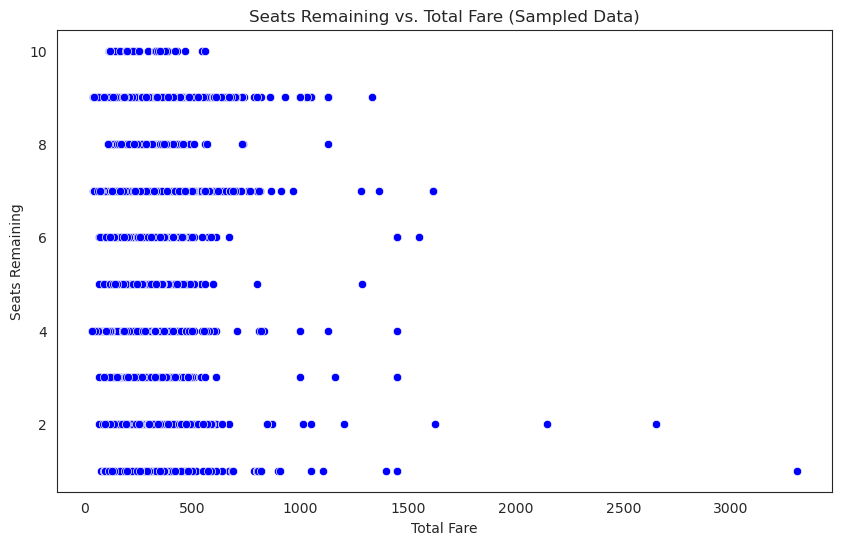

In [13]:
# Create a scatter plot to visualize the relationship between totalFare and seatsRemaining for a sample dataset
plt.figure(figsize=(10, 6))
sns.scatterplot(x='totalFare', y='seatsRemaining', data=sample_sdf.toPandas(), color='blue')
plt.title('Seats Remaining vs. Total Fare (Sampled Data)')
plt.xlabel('Total Fare')
plt.ylabel('Seats Remaining')
plt.show()

In [14]:
# Drop unnecessary pre-existing columns
columns_to_drop = ["StartingAirport_Index", "DestinationAirport_Index", 
                   "StartingAirport_OneHot", "DestinationAirport_OneHot"]
sdf_cleaned = sdf_cleaned.drop(*columns_to_drop)

# Define the stages of the pipeline
# String Indexing categorical columns
indexer_airport_start = StringIndexer(inputCol="StartingAirport", outputCol="StartingAirport_Index")
indexer_airport_dest = StringIndexer(inputCol="DestinationAirport", outputCol="DestinationAirport_Index")

# One-Hot Encoding indexed columns
encoder_airport_start = OneHotEncoder(inputCol="StartingAirport_Index", outputCol="StartingAirport_OneHot")
encoder_airport_dest = OneHotEncoder(inputCol="DestinationAirport_Index", outputCol="DestinationAirport_OneHot")

# Vector Assembling features (excluding totalFare)
feature_columns = [
    "StartingAirport_OneHot", "DestinationAirport_OneHot", 
    "totalTravelDistance", "DaysInAdvance", "FlightDayOfWeek"
]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Create the pipeline
flights_pipeline = Pipeline(stages=[
    indexer_airport_start, indexer_airport_dest,
    encoder_airport_start, encoder_airport_dest,
    assembler
])

# Fit the pipeline to the data and transform
transformed_sdf = flights_pipeline.fit(sdf_cleaned).transform(sdf_cleaned)

# Show a sample of the transformed features
transformed_sdf.select(
    "StartingAirport", "DestinationAirport", "totalFare", "totalTravelDistance", 
    "DaysInAdvance", "FlightDayOfWeek", "features"
).show(30, truncate=False)



+---------------+------------------+---------+-------------------+-------------+---------------+-----------------------------------------------+
|StartingAirport|DestinationAirport|totalFare|totalTravelDistance|DaysInAdvance|FlightDayOfWeek|features                                       |
+---------------+------------------+---------+-------------------+-------------+---------------+-----------------------------------------------+
|IAD            |EWR               |218.6    |221.0              |48           |1              |(33,[14,22,30,31,32],[1.0,1.0,221.0,48.0,1.0]) |
|IAD            |LAX               |458.6    |2295.0             |48           |1              |(33,[14,18,30,31,32],[1.0,1.0,2295.0,48.0,1.0])|
|JFK            |ATL               |173.6    |762.0              |48           |1              |(33,[5,19,30,31,32],[1.0,1.0,762.0,48.0,1.0])  |
|JFK            |ATL               |184.35   |762.0              |48           |1              |(33,[5,19,30,31,32],[1.0,1.0,762.0

In [15]:
# Split the data into training and testing datasets
train_data, test_data = transformed_sdf.randomSplit([0.8, 0.2], seed=42)


# Initialize the Linear Regression model
linear_reg = LinearRegression(featuresCol="features", labelCol="totalFare")

# Train the regression model
regression_model = linear_reg.fit(train_data)

# Test the model on the test data
test_results = regression_model.transform(test_data)

# Show the test results, including predictions and actual fare
test_results.select(
    'StartingAirport',
    'DestinationAirport',
    'totalFare',  # Actual fares
    'prediction'  # Predicted fares
).show(30, truncate=False)

# Evaluate model performance using regression metrics
from pyspark.ml.evaluation import RegressionEvaluator

# RMSE
rmse_evaluator = RegressionEvaluator(labelCol='totalFare', predictionCol='prediction', metricName='rmse')
rmse = rmse_evaluator.evaluate(test_results)

# R2
r2_evaluator = RegressionEvaluator(labelCol='totalFare', predictionCol='prediction', metricName='r2')
r2 = r2_evaluator.evaluate(test_results)

# MAE
mae_evaluator = RegressionEvaluator(labelCol='totalFare', predictionCol='prediction', metricName='mae')
mae = mae_evaluator.evaluate(test_results)

# Print performance summary
print("\nModel Performance on Test Data:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")


24/12/03 04:08:22 WARN Instrumentation: [a0d274cd] regParam is zero, which might cause numerical instability and overfitting.


+---------------+------------------+---------+------------------+
|StartingAirport|DestinationAirport|totalFare|prediction        |
+---------------+------------------+---------+------------------+
|JFK            |ATL               |513.6    |213.8907630080825 |
|JFK            |BOS               |93.6     |123.0983298272505 |
|JFK            |DEN               |273.6    |297.92833885057183|
|JFK            |LAX               |398.6    |373.5684913391692 |
|JFK            |ORD               |191.6    |201.13220007712047|
|JFK            |SFO               |378.61   |438.6474333673944 |
|LAX            |BOS               |1407.6   |482.41419213727875|
|LAX            |IAD               |678.6    |490.36839578652183|
|LAX            |SFO               |358.6    |223.12579945601567|
|LGA            |ATL               |233.6    |199.91700624470556|
|LGA            |ATL               |233.6    |199.91700624470556|
|LGA            |ATL               |183.6    |199.91700624470556|
|LGA      


Model Performance on Test Data:
Root Mean Squared Error (RMSE): 131.6934115929015
R2: 0.3462083968493257
Mean Absolute Error (MAE): 81.74047122346056


In [17]:
# Build the parameter grid
param_grid = (
    ParamGridBuilder()
    .addGrid(linear_reg.regParam, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0])
    .addGrid(linear_reg.elasticNetParam, [0, 0.5, 1])
    .build()
)

train_validation_split = TrainValidationSplit(
    estimator=linear_reg,
    estimatorParamMaps=param_grid,
    evaluator=RegressionEvaluator(labelCol="totalFare", predictionCol="prediction", metricName="rmse"),
    trainRatio=0.8  # 80% for training, 20% for validation
)

#Train the model on your training dataset with hyperparameter tuning
tuned_model = train_validation_split.fit(train_data)


# Define the evaluator
evaluator = RegressionEvaluator(labelCol='totalFare', predictionCol='prediction', metricName='rmse')

# Create the CrossValidator
cv = CrossValidator(
    estimator=linear_reg,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5,  # 5-fold cross-validation
    parallelism=4  
)

best_model = tuned_model.bestModel

# Test the best model on the test dataset
test_results = best_model.transform(test_data)

# Evaluate RMSE, R2, and MAE on the test data
rmse = RegressionEvaluator(labelCol="totalFare", predictionCol="prediction", metricName="rmse").evaluate(test_results)
r2 = RegressionEvaluator(labelCol="totalFare", predictionCol="prediction", metricName="r2").evaluate(test_results)
mae = RegressionEvaluator(labelCol="totalFare", predictionCol="prediction", metricName="mae").evaluate(test_results)

print("\nTuned Model Performance on Test Data:")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")


24/12/03 04:09:14 WARN Instrumentation: [a10fce8c] regParam is zero, which might cause numerical instability and overfitting.
24/12/03 04:09:18 WARN Instrumentation: [35c579fd] regParam is zero, which might cause numerical instability and overfitting.
24/12/03 04:09:18 WARN Instrumentation: [42f75f93] regParam is zero, which might cause numerical instability and overfitting.
24/12/03 04:09:26 WARN Instrumentation: [f77f1999] regParam is zero, which might cause numerical instability and overfitting.



Tuned Model Performance on Test Data:
Root Mean Squared Error (RMSE): 131.6934115929015
R2: 0.3462083968493257
Mean Absolute Error (MAE): 81.74047122346056


In [18]:
# Extract and print the best model's hyperparameters
param_map = tuned_model.bestModel.extractParamMap()
print("\nBest Model Hyperparameters:")
for param, value in param_map.items():
    print(f"{param.name}: {value}")


Best Model Hyperparameters:
aggregationDepth: 2
elasticNetParam: 0.0
epsilon: 1.35
featuresCol: features
fitIntercept: True
labelCol: totalFare
loss: squaredError
maxBlockSizeInMB: 0.0
maxIter: 100
predictionCol: prediction
regParam: 0.0
solver: auto
standardization: True
tol: 1e-06


In [19]:
# Path to save the best model
model_save_path = "gs://my-bigdata-project-es/best_model"

# Save the model
best_model.write().overwrite().save(model_save_path)

In [20]:
# Get the coefficients and intercept from the model
coefficients = regression_model.coefficients
intercept = regression_model.intercept

# Get the feature names
feature_names = assembler.getInputCols()

# Map coefficients to feature names
print("\nFeature Importance (Coefficients):")
for feature, coeff in zip(feature_names, coefficients):
    print(f"{feature}: {coeff:.4f}")

# Print the intercept
print(f"\nIntercept: {intercept:.4f}")


Feature Importance (Coefficients):
StartingAirport_OneHot: 19.1729
DestinationAirport_OneHot: -25.4345
totalTravelDistance: -53.8664
DaysInAdvance: 20.0081
FlightDayOfWeek: 55.2383

Intercept: 169.4714
